<a id='Time_Series_SARIMAX.ipynb'></a>
# Autoarima modeling
1.1 [autoarima](#auto-arima-no-exog)<br>
1.2 [autoarima with exogenous variable](#auto-arima-with-exog)<br>
1.3 [results](#results)

Arima (AutoRegressive Integrated Moving Average) is a popular and widely used method for time series forecasting. In this notebook we developed two arima models for housing price forecasting. The first model is a univariate time series Arima model in which we only used the historical housing price to forecast the housing price in future (univariate Time Series Forecasting). In the second model we used two exogenous variables which were the numbre of issued construction permits per month and monthly crime rate to predict the future housing price.

### Checking for stationaity
To test for stationarity of the time series we used augmented dicky fuller test.
To find what differencing will make it stationary we used the maximum value between the adf and kpss tests.
We plotted the acf and pacf plots to identify the correct model parameters. 

### ACF and PACF plots
The ACF plot shows the correlation between a time series and the lagged  version of itself. 
The PACF plot also shows the correlation between a time series and the lagged  version of itself after we removed the correlation effects of the smaller lags.  

### Model parameters
The parameters of the arima model are: <br>
    **p**: number of lagged observation considered in the model<br>
    **d**: degree of differencing<br>
    **q**: the order of moving average<br>


In general:
1. If the amplitude of the tail soff with increasing lags and PACF cuts off after p lags we have AR(p) model.
2. If the amplitude of ACF cuts of after q lags and PACF tails off we have MA(q) model
3. If both ACF and PACF amplitudes tail off then we have ARMA(p,q) model and we can't find the p and q value from the plots.


We used Akaike information criterion (AIC) and Bayesian information criterion (BIC) for model selection. Both BIC and AIC penalize models that are overly complex and have more parameters.

### Model diagnostics
For model diagnostics we looked at the residul plots. Residuals of an ideal model should be uncorrelated white Guassian noise centered around zero.

#### plots
1. **Standardized residuals Plot**: In this plot the residuals should be distributed randomly with no obvious structure

2. **Histogram plus estimated density plot** shows the distribution of the residuals. The KDE plot and the normal plot should overlay on each other in a good model 

3. **Normal Q-Q Plot** showing the distribution of a model residual compared to a normal distribution. The data points should lay on the normal distribution line.

4. **Correlogram Plot** that shows the ACF plot of the residuals.

#### test statistics
We also used the model summary to check the results of **Ljung-Box P(Q)** and **Jarque-Bera P(JB)** test statistics. 

prob(Q) is the p-value for the test with the null hypothesis that the residuals are not correlated.<br> 
prob(JB) is the p-value for the test with the null hypothesis that the residuals are normally distributed.<br>


In [2]:
import glob, os
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import requests 
import json
from collections import defaultdict
import pickle
import requests
from bs4 import BeautifulSoup
from pandas_profiling import ProfileReport
from sodapy import Socrata
import dill
from geopy.geocoders import Nominatim
import geopy
from ediblepickle import checkpoint
from retrying import retry
import requests
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
import cloudscraper
from time import sleep
from sklearn.feature_extraction import DictVectorizer
from pmdarima.arima import ndiffs
from statsmodels.tsa.seasonal import seasonal_decompose 
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score


from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose

In [3]:
sns.set()

In [4]:
#reading the data
Housing_price_since1996 = pd.read_csv('./Chicago_Housing_Datasets/All_cities_Monthly_HousingPrice_1996to2020.csv')
Housing_price_since1996 = Housing_price_since1996[Housing_price_since1996.City == 'Chicago']
Housing_price_since1996.drop(['CountyName', 'Metro', 'City', 'State', 'StateName', 'RegionType','SizeRank', 'RegionID'], axis=1, inplace=True)

In [5]:
Housing_price_since1996.rename(columns={'RegionName': 'zipcode'}, inplace=True)
Housing_price_since1996.reset_index(drop=True,inplace=True)
Housing_price_since1996.head()

,zipcode,1996-01-31,1996-02-29,1996-03-31,1996-04-30,1996-05-31,1996-06-30,1996-07-31,1996-08-31,1996-09-30,...,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31,2020-11-30
0,60657,203459.0,203308.0,202913.0,202782.0,202237.0,202415.0,202209.0,202796.0,203655.0,...,473138.0,474705.0,475762.0,475995.0,476428.0,477687.0,479702.0,482493.0,485306.0,488055.0
1,60614,271728.0,271479.0,270979.0,270842.0,270189.0,270275.0,269799.0,270340.0,271380.0,...,608666.0,609279.0,608927.0,608721.0,608756.0,609901.0,611415.0,614273.0,617081.0,620179.0
2,60640,120004.0,119659.0,119308.0,119195.0,118944.0,119065.0,119070.0,119736.0,120564.0,...,304818.0,306382.0,307129.0,307447.0,307954.0,309306.0,311171.0,313906.0,316627.0,319125.0
3,60647,163786.0,163928.0,164230.0,164805.0,164995.0,165403.0,165985.0,167153.0,168132.0,...,457844.0,461096.0,464069.0,465748.0,467741.0,470508.0,473766.0,477721.0,481544.0,484796.0
4,60618,198594.0,198432.0,198378.0,198907.0,198958.0,198893.0,198251.0,198398.0,199290.0,...,465000.0,467073.0,468449.0,469247.0,469992.0,471869.0,474651.0,478994.0,483192.0,486576.0


In [6]:
Housing_price_since1996.zipcode.unique()

array([60657, 60614, 60640, 60647, 60618, 60613, 60625, 60629, 60610,
       60619, 60611, 60617, 60620, 60634, 60628, 60649, 60626, 60622,
       60616, 60615, 60641, 60660, 60637, 60608, 60638, 60639, 60630,
       60643, 60623, 60632, 60605, 60609, 60645, 60654, 60651, 60653,
       60644, 60607, 60612, 60659, 60652, 60631, 60656, 60624, 60601,
       60642, 60655, 60646, 60661, 60633, 60606, 60602, 60603, 60604])

In [7]:
Housing_price_since1996 = Housing_price_since1996.melt(id_vars='zipcode', value_name='price', var_name='date')
print(Housing_price_since1996.dtypes)
Housing_price_since1996.head()

zipcode      int64
date        object
price      float64
dtype: object


,zipcode,date,price
0,60657,1996-01-31,203459.0
1,60614,1996-01-31,271728.0
2,60640,1996-01-31,120004.0
3,60647,1996-01-31,163786.0
4,60618,1996-01-31,198594.0


In [8]:
Housing_price_since1996.date = pd.to_datetime(Housing_price_since1996.date, format='%Y-%m-%d')
Housing_price_since1996.zipcode = Housing_price_since1996.zipcode.astype(str)
Housing_price_since1996.sort_values('date', inplace=True)
Housing_price_since1996 = Housing_price_since1996[(Housing_price_since1996.date.dt.year>=2006) & (Housing_price_since1996.date.dt.year<2020)]
Housing_price_since1996.shape

(9072, 3)

<AxesSubplot:xlabel='price', ylabel='Count'>

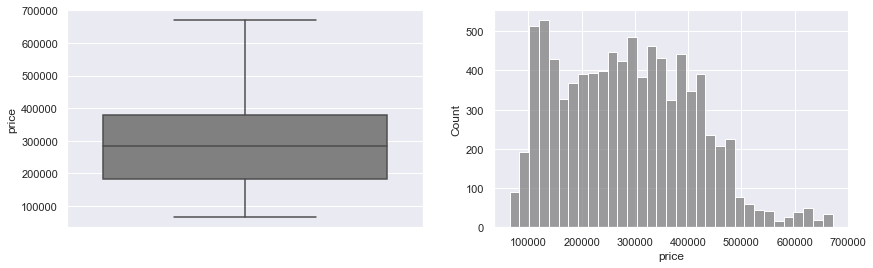

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(14,4))
sns.boxplot(y= 'price',data=Housing_price_since1996.dropna(), color='gray',ax=ax1)
sns.histplot(x= 'price', data=Housing_price_since1996.dropna(),color='gray', ax=ax2)
#price distribution has skewed distribution 

In [10]:
# creating dataframe for each zipcode
dict_df_by_zip = defaultdict(str)
for zipcode, df in Housing_price_since1996.groupby('zipcode'):
    dict_df_by_zip[zipcode] = df

In [11]:
# zipcodes with missing data
Housing_price_since1996[Housing_price_since1996.price.isna()].zipcode.unique()

array(['60651', '60623', '60603', '60604'], dtype=object)

In [12]:
#approximating the missing data for zipcodes based on the neighborhood zipcodes

missing_values_60623 = Housing_price_since1996.loc[Housing_price_since1996.zipcode.str.contains('60644|60609', regex=True)].groupby('date').mean().round()
missing_values_60603 = Housing_price_since1996.loc[Housing_price_since1996.zipcode.str.contains('60611', regex=True)].groupby('date').mean().round()+200000
missing_values_60604 = Housing_price_since1996.loc[Housing_price_since1996.zipcode.str.contains('60601|60602|60606', regex=True)].groupby('date').mean().round()
missing_values_60624 =Housing_price_since1996.loc[Housing_price_since1996.zipcode.str.contains('60612|60644', regex=True)].groupby('date').mean().round()
missing_values_60651 = Housing_price_since1996.loc[Housing_price_since1996.zipcode.str.contains('60644', regex=True)].groupby('date').mean().round()-5000
missing_values_60661 = Housing_price_since1996.loc[Housing_price_since1996.zipcode.str.contains('60607', regex=True)].groupby('date').mean().round()



dict_df_by_zip['60603'] = dict_df_by_zip['60603'].set_index('date').fillna(missing_values_60603).reset_index()
dict_df_by_zip['60604'] = dict_df_by_zip['60604'].set_index('date').fillna(missing_values_60604).reset_index()
dict_df_by_zip['60623'] = dict_df_by_zip['60623'].set_index('date').fillna(missing_values_60623).reset_index()
dict_df_by_zip['60624'] = dict_df_by_zip['60624'].set_index('date').fillna(missing_values_60624).reset_index()
dict_df_by_zip['60651'] = dict_df_by_zip['60651'].set_index('date').fillna(missing_values_60651).reset_index()
dict_df_by_zip['60661'] = dict_df_by_zip['60661'].set_index('date').fillna(missing_values_60661).reset_index()
dict_df_by_zip['60653'] = dict_df_by_zip['60653'].fillna(method='bfill')

In [13]:
#check the imputing results
Housing_price_since1996[Housing_price_since1996.zipcode=='60603']

,zipcode,date,price
6532,60603,2006-01-31,NaN
6586,60603,2006-02-28,NaN
6640,60603,2006-03-31,NaN
6694,60603,2006-04-30,NaN
6748,60603,2006-05-31,NaN
...,...,...,...
15334,60603,2019-08-31,617621.0
15388,60603,2019-09-30,615917.0
15442,60603,2019-10-31,617082.0
15496,60603,2019-11-30,616399.0


In [14]:
def get_monthly_df(adict):
    monthly_df_by_zip = defaultdict(str)
    for key in dict_df_by_zip:
        monthly_df_by_zip[key] = dict_df_by_zip[key].set_index('date')
    return monthly_df_by_zip
df_price_by_zipcode = get_monthly_df(dict_df_by_zip) 

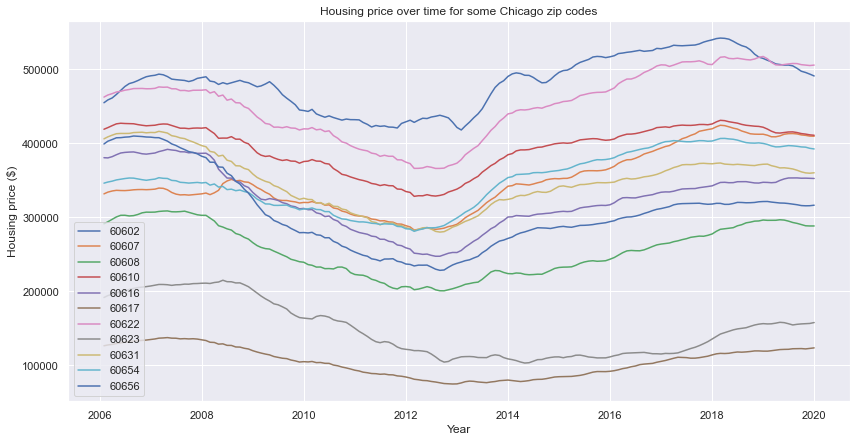

In [15]:
#plotting housing price over time for given zipcodes
def plot_price(adict, selected_zipcodes):
    fig, ax = plt.subplots(figsize=(14,7))
    for zipcode in selected_zipcodes:
        ax.plot(adict[zipcode].price, label=zipcode)
        plt.legend()
    plt.ylabel('Housing price ($)')
    plt.xlabel('Year')
    plt.title('Housing price over time for some Chicago zip codes')
    
selected_zipcodes = ['60602','60607', '60608', '60610', '60616', '60617','60622', '60623','60631', '60654', '60656']
plot_price(df_price_by_zipcode,selected_zipcodes)

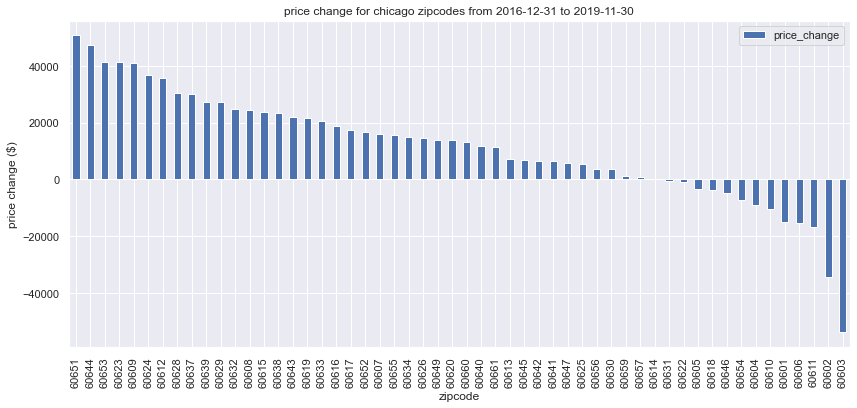

In [16]:
# Housing price change between 2020 and 2017

def get_price_change(init_date = '2016-12-31', end_date = '2019-11-30'):
    price_change = []
    for zipcode in Housing_price_since1996.zipcode.unique():
        df = dict_df_by_zip[zipcode]
        zipcode_price_change = df.loc[df.date==end_date, 'price'].values[0] - df.loc[df.date==init_date, 'price'].values[0]
        price_change.append((zipcode, zipcode_price_change))
    price_change_df = pd.DataFrame(price_change, columns=['zipcode', 'price_change'])
    price_change_df.sort_values('price_change', ascending=False).plot(x='zipcode',kind='bar', figsize=(14,6))
    plt.title(f'price change for chicago zipcodes from {init_date} to {end_date}')
    plt.ylabel('price change ($)')
    return price_change
price_change = get_price_change()


### Auto Arima with no exogenous variable
<a id=auto-arima-no-exog></a>

In [17]:
#Estimate ARIMA differencing term

sample_zipcode = df_price_by_zipcode['60608'].drop('zipcode', axis=1)
kpss_diffs = ndiffs(sample_zipcode, alpha=0.05, test='kpss')
adf_diffs = ndiffs(sample_zipcode, alpha=0.05, test='adf')
n_diffs = max(adf_diffs, kpss_diffs)
print(n_diffs)

2


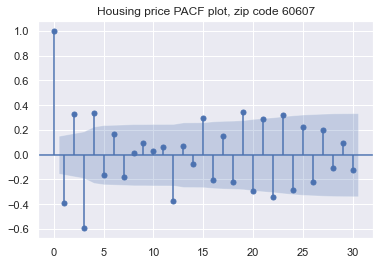

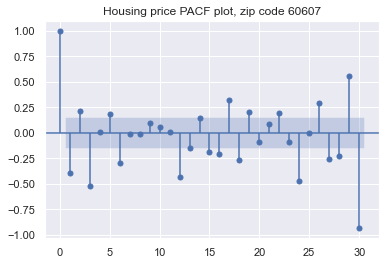

In [75]:
# plot_acf(get_merged_data('60607').price.diff().diff().dropna(), lags=30, title = 'Housing price PACF plot, zip code 60607')
# plot_pacf(get_merged_data('60607').price.diff().diff().dropna(), lags=30, title = 'Housing price PACF plot, zip code 60607');

Here we used auto_arima to automatically find the best parameters for the ARIMA model. [Reference](https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html)

"Auto-ARIMA works by conducting differencing tests (i.e., Kwiatkowski–Phillips–Schmidt–Shin, Augmented Dickey-Fuller or Phillips–Perron) to determine the order of differencing, d, and then fitting models within ranges of defined start_p, max_p, start_q, max_q ranges. If the seasonal optional is enabled, auto-ARIMA also seeks to identify the optimal P and Q hyper- parameters after conducting the Canova-Hansen to determine the optimal order of seasonal differencing, D. 

In order to find the best model, auto-ARIMA optimizes for a given information_criterion, one of (‘aic’, ‘aicc’, ‘bic’, ‘hqic’, ‘oob’) (Akaike Information Criterion, Corrected Akaike Information Criterion, Bayesian Information Criterion, Hannan-Quinn Information Criterion, or “out of bag”–for validation scoring–respectively) and returns the ARIMA which minimizes the value."

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  132
Model:               SARIMAX(0, 2, 0)   Log Likelihood               -1218.981
Date:                Sun, 16 May 2021   AIC                           2439.961
Time:                        22:59:06   BIC                           2442.829
Sample:                             0   HQIC                          2441.127
                                - 132                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      8.043e+06   7.98e+05     10.081      0.000    6.48e+06    9.61e+06
Ljung-Box (L1) (Q):                  79.15   Jarque-Bera (JB):                 5.97
Prob(Q):                              0.00   Pr

,forecast,actual_price
date,,
2019-12-31,560749.0,505352.0


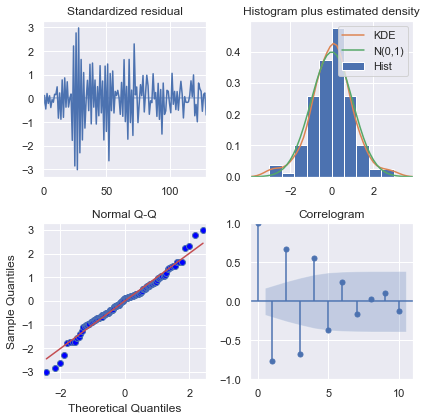

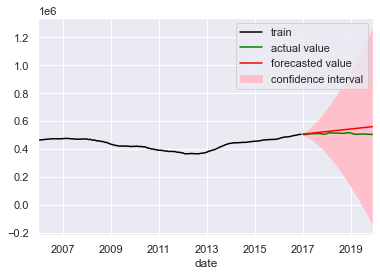

In [63]:
def price_prediction(zipcode, forecast_periods= 36, model_info=False, plot_diagnostic=False, plot_forecast=False, summary=False):
    df = df_price_by_zipcode[zipcode]
    df = df.iloc[df.index.year<2020]
#     split_idx = int(df.shape[0]*split)
    indx = -1*forecast_periods
    train = df[:indx]
    test = df[indx:]
    x_train = train.price
    x_test = test.price
    model = auto_arima(x_train,
                       stepwise=True,
                       seasonal=False,
                       max_p=4,
                       max_q=4,
                       suppress_warnings=True,
                       error_action="ignore"
                       )
    if model_info:
        print(f'order: {model.order}')
        print(f"{zipcode} zipcode aic: {model.aic()}")
    if plot_diagnostic:
        model.plot_diagnostics(figsize=(6,6));
        plt.tight_layout()
    if summary:
        print(model.summary())
    fc, confint = model.predict(forecast_periods, return_conf_int=True)
    fc_df= pd.DataFrame(fc, index= test.index, columns=['forecast'])
    fc_df['actual_price'] = x_test
    confint_df = pd.DataFrame(confint, columns=['lower', 'upper'], index=fc_df.index)
    if plot_forecast:
        fig, ax = plt.subplots()
        x_train.plot(ax=ax, label='train', color='black')
        x_test.plot(label='actual value', color='green', ax=ax)
        fc_df.forecast.plot(color='red', ax=ax,label='forecasted value')
        plt.fill_between(x=confint_df.index, y1=confint_df['lower'], y2=confint_df['upper'], color='pink', label='confidence interval')
        plt.legend()
    return fc_df.iloc[-1:,:]
price_prediction('60622', plot_diagnostic=True, plot_forecast=True, summary=True) 

In [59]:
def get_total_error_for_all_zipcodes(list_of_zipcodes, func, forecast_periods= 36):
    df = pd.DataFrame()
    for zipcode in list_of_zipcodes:
        temp = func(zipcode, forecast_periods= forecast_periods)
        df = pd.concat((df,temp))
    mse = np.sqrt(mean_squared_error(df.actual_price, df.forecast)).round(2)
    mae = mean_absolute_error(df.actual_price, df.forecast).round(2)
    r2 = r2_score(df.actual_price, df.forecast)
    print(f'RMSE = {mse}\nMAE={mae}\nr_squared:={r2}')
all_zipcodes_except_outliers = ['60657', '60632', '60605', '60609', '60645', '60654', '60651']
get_total_error_for_all_zipcodes(all_zipcodes_except_outliers, price_prediction)

RMSE = 49400.49
MAE=39058.34
r_squared:=0.7563988223131056


In [21]:
# Using Exogenous variables to find the price

In [22]:
#getting the data 
"""
client = Socrata("data.cityofchicago.org", None)
select = 'id, permit_, application_start_date, issue_date, street_number, street_name, community_area, census_tract, ward,latitude,longitude'
results = client.get("ydr8-5enu", select = select, where= "permit_type in ('PERMIT - NEW CONSTRUCTION','PERMIT - WRECKING/DEMOLITION','PERMIT - RENOVATION/ALTERATION')", limit=174534)
# Convert to pandas DataFrame
building = pd.DataFrame.from_records(results)
"""

#saving the data 
"""
with open("building_permit", "wb") as dill_file:
    dill.dump(building, dill_file)   
"""

#reading the data 
with open("building_permit", "rb") as dill_file:
    building_permit = dill.load(dill_file)
building_permit.head()

,id,permit_,application_start_date,issue_date,street_number,street_name,community_area,census_tract,ward,latitude,longitude
0,2015693,100276612,2009-03-26T00:00:00.000,2010-06-14T00:00:00.000,5439,DAMEN,61,6117,16,41.794585511,-87.674174892
1,2053303,100293285,2009-06-16T00:00:00.000,2009-07-16T00:00:00.000,2946,HOYNE,5,514,1,41.935473196,-87.680810483
2,3125307,100876352,2020-10-14T00:00:00.000,2020-11-10T00:00:00.000,10000,OHARE,76,980000,41,NaN,NaN
3,3110706,100864812,2020-04-21T00:00:00.000,2020-07-01T00:00:00.000,10000,OHARE,76,980000,41,NaN,NaN
4,2068267,100300715,2009-07-24T00:00:00.000,2009-08-31T00:00:00.000,2715,KENMORE,7,704,32,41.930475362,-87.654962896


In [23]:
building_permit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174534 entries, 0 to 174533
Data columns (total 11 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   id                      174534 non-null  object
 1   permit_                 174534 non-null  object
 2   application_start_date  174374 non-null  object
 3   issue_date              174534 non-null  object
 4   street_number           174534 non-null  object
 5   street_name             174534 non-null  object
 6   community_area          145676 non-null  object
 7   census_tract            145171 non-null  object
 8   ward                    145640 non-null  object
 9   latitude                174058 non-null  object
 10  longitude               174058 non-null  object
dtypes: object(11)
memory usage: 14.6+ MB


In [24]:
building_permit.application_start_date = pd.to_datetime(building_permit.application_start_date)
building_permit.issue_date = pd.to_datetime(building_permit.issue_date)

#checking for data with missing values for lat and long
missing_lat_long = building_permit[(building_permit['latitude'].isna()) | (building_permit['longitude'].isna())]

#there is no more information to impute these missing values so removed them from the data
building_lat_long = building_permit[(building_permit['latitude'].notnull()) & (building_permit['longitude'].notnull())]
building_lat_long.head(3)

,id,permit_,application_start_date,issue_date,street_number,street_name,community_area,census_tract,ward,latitude,longitude
0,2015693,100276612,2009-03-26,2010-06-14,5439,DAMEN,61,6117,16,41.794585511,-87.674174892
1,2053303,100293285,2009-06-16,2009-07-16,2946,HOYNE,5,514,1,41.935473196,-87.680810483
4,2068267,100300715,2009-07-24,2009-08-31,2715,KENMORE,7,704,32,41.930475362,-87.654962896


In [25]:
# Getting zipcode from lat, long data  
"""def find_zipcode_local(df):
    zipcode = []
    for row in tqdm(df.itertuples()):
        response = requests.get('http://localhost:3000/?lat={}&long={}'.format(row.latitude, row.longitude))
        zipcode.append(response.json()['zip'])
    return zipcode
building_zipcodes = find_zipcode_local(building_lat_long)

#saving zipcode data 
with open('building_zipcodes', 'wb') as dill_file:
    dill.dump(building_zipcodes, dill_file)"""

#reading zipcode data 
with open('building_zipcodes', 'rb') as f:
    construction_zipcode = dill.load(f)
building_lat_long['zipcode'] = construction_zipcode

<ipython-input-25-d5d7b37f39d5>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  building_lat_long['zipcode'] = construction_zipcode


In [26]:
#confirm that missing zipcodes are located outside of chicago
building_lat_long[building_lat_long.zipcode.isna()].head()

,id,permit_,application_start_date,issue_date,street_number,street_name,community_area,census_tract,ward,latitude,longitude,zipcode
1169,1648980,100093725,2006-02-02,2006-02-02,11601,TOUHY,NaN,NaN,NaN,42.008536401,-87.914428439,None
1809,1668118,100105612,2006-04-20,2006-04-21,11601,TOUHY,NaN,NaN,NaN,42.008536401,-87.914428439,None
3281,1722992,100136817,2006-09-13,2006-09-13,11601,TOUHY,NaN,NaN,NaN,42.008536401,-87.914428439,None
3282,1723010,100136826,2006-09-13,2006-09-13,11601,TOUHY,NaN,NaN,NaN,42.008536401,-87.914428439,None
3283,1723017,100136828,2006-09-13,2006-09-13,11601,TOUHY,NaN,NaN,NaN,42.008536401,-87.914428439,None


In [27]:
#removing data with missing application start date
building_lat_long = building_lat_long.dropna(subset=['application_start_date'])

building_df = building_lat_long.dropna(subset=['latitude', 'longitude'], axis=0).copy()
building_df.rename(columns={'permit_':'permit'}, inplace=True)
building_df = building_df[(building_df.application_start_date.dt.year>=2006) & (building_df.application_start_date.dt.year<2020)]

In [28]:
# Finding monthly construction count per zipcode
df_construction_by_zipcode = defaultdict(str)
daily_building_permits = building_df.groupby(['application_start_date', 'zipcode'])['permit'].count().reset_index()
daily_building_permits['construction_count'] = daily_building_permits.permit
for zipcode, df in daily_building_permits.groupby('zipcode'):
    df_construction_by_zipcode[zipcode]= df.resample('M', on ='application_start_date')[['construction_count']].sum()
df_construction_by_zipcode['60628'].head()


,construction_count
application_start_date,
2006-01-31,11
2006-02-28,15
2006-03-31,8
2006-04-30,17
2006-05-31,14


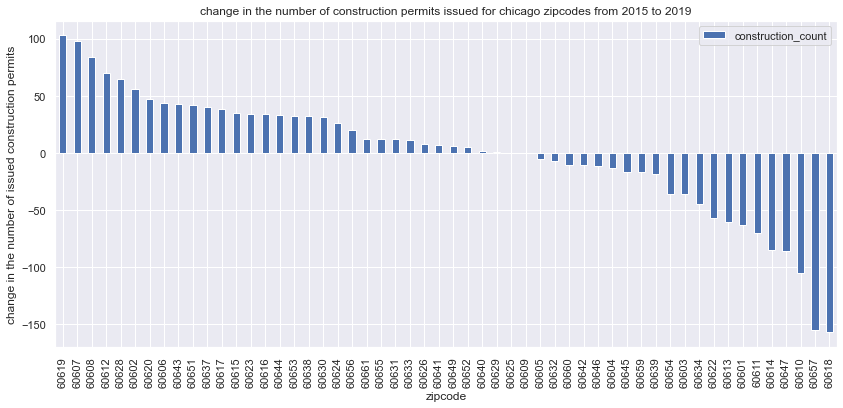

In [29]:
def get_construction_change(init_date = 2015, end_date = 2019):
    construction_change = []
    for zipcode in Housing_price_since1996.zipcode.unique():
        df = df_construction_by_zipcode[zipcode]
        zipcode_construction_change = df.loc[df.index.year ==end_date, 'construction_count'].sum() - df.loc[df.index.year ==init_date, 'construction_count'].sum()
        construction_change.append((zipcode, zipcode_construction_change))
    construction_df = pd.DataFrame(construction_change, columns=['zipcode', 'construction_count'])
    construction_df.sort_values('construction_count', ascending=False).plot(x='zipcode',kind='bar', figsize=(14,6))
    plt.title(f'change in the number of construction permits issued for chicago zipcodes from {init_date} to {end_date}')
    plt.ylabel('change in the number of issued construction permits')
    return price_change
construction_change = get_construction_change()

In [30]:
# getting crime data
"""#getting the data 

client = Socrata("data.cityofchicago.org", None)
select = 'id, date, primary_type, description, location_description, arrest, domestic, year, latitude, longitude'
results = client.get("ijzp-q8t2",select=select, limit=7301707)
# Convert to pandas DataFrame
crime_results = pd.DataFrame.from_records(results)"""
#saving the data
"""with open("chicago_crime_2001_2020", "wb") as dill_file:
    dill.dump(crime_results, dill_file)"""
#reading the data
with open("chicago_crime_2001_2020", "rb") as f:
    crime= dill.load(f)
crime.head(3)

,id,date,primary_type,description,location_description,arrest,domestic,year,latitude,longitude
0,10224738,2015-09-05T13:30:00.000,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,2015,41.815117282,-87.669999562
1,10224739,2015-09-04T11:30:00.000,THEFT,POCKET-PICKING,CTA BUS,False,False,2015,41.895080471,-87.765400451
2,11646166,2018-09-01T00:01:00.000,THEFT,OVER $500,RESIDENCE,False,True,2018,NaN,NaN


In [31]:
crime_df = crime[(crime.latitude.notnull()) & (crime.longitude.notnull())]

In [32]:
#get zipcode from lat and long
"""def find_zipcode_local(lat, long):
    response = requests.get('http://localhost:3000/?lat={}&long={}'.format(lat,long))
    zipcode = response.json()['zip']
    return zipcode

lat = list(crime_df.latitude)
long = list(crime_df.longitude)
results = []
for i in tqdm(range(len(lat))):
    results.append(find_zipcode_local(lat[i], long[i]))
    """
#saving the data 
"""with open("crime_zipcode", "wb") as dill_file:
    dill.dump(results, dill_file)"""


    


'with open("crime_zipcode", "wb") as dill_file:\n    dill.dump(results, dill_file)'

In [33]:
#reading the data
#with open("crime_zipcode", "rb") as f:
#    crime_zipcode_data =dill.load(f)
    
#crime_df['zipcode'] = crime_zipcode_data
# crime_df.date = pd.to_datetime(crime_df.date)
# crime_df_daily = crime_df.groupby(['date','zipcode']).agg({'arrest':sum, 'domestic':sum, 'id':len, 'primary_type':pd.Series.mode})
# crime_df_daily.rename(columns={'id':'crime_count'},inplace=True)
# crime_df_daily.reset_index(inplace=True)
# crime_df_daily_after_2006 = crime_df_daily.loc[crime_df_daily.date.dt.year>2005]
# crime_df_daily_after_2006.to_pickle("crime_daily_df_2006.pkl")

In [34]:
crime_df_daily_after_2006 = pd.read_pickle("crime_daily_df_2006.pkl")
crime_df_daily_after_2006 = crime_df_daily_after_2006[['date','zipcode','crime_count']]
crime_df_daily_after_2006 = crime_df_daily_after_2006[crime_df_daily_after_2006.date.dt.year<2020]

In [35]:
df_crime_by_zipcode = defaultdict(str)
for zipcode, df in crime_df_daily_after_2006.groupby('zipcode'):
    df_crime_by_zipcode[zipcode] = df.set_index('date').resample('M').sum()
df_crime_by_zipcode['60607'].head(3)

,crime_count
date,
2006-01-31,308
2006-02-28,255
2006-03-31,337


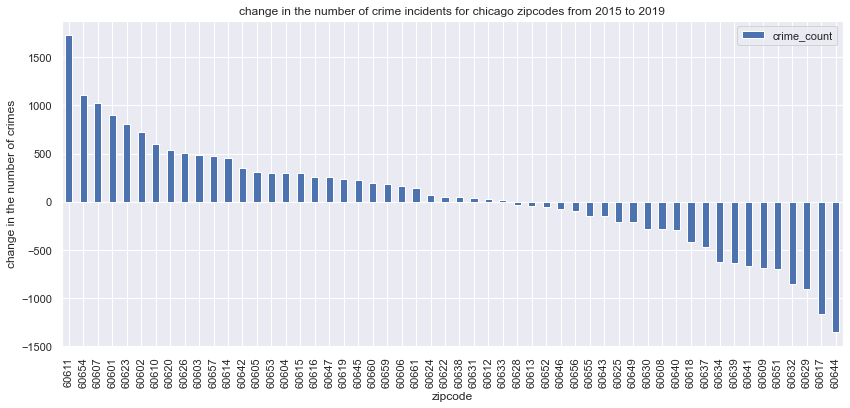

In [36]:
def get_crime_change(init_date = 2015, end_date = 2019):
    crime_change = []
    for zipcode in Housing_price_since1996.zipcode.unique():
        df = df_crime_by_zipcode[zipcode]
        zipcode_crime_change = df.loc[df.index.year ==end_date, 'crime_count'].sum() - df.loc[df.index.year ==init_date, 'crime_count'].sum()
        crime_change.append((zipcode, zipcode_crime_change))
    crime_df = pd.DataFrame(crime_change, columns=['zipcode', 'crime_count'])
    crime_df.sort_values('crime_count', ascending=False).plot(x='zipcode',kind='bar', figsize=(14,6))
    plt.title(f'change in the number of crime incidents for chicago zipcodes from {init_date} to {end_date}')
    plt.ylabel('change in the number of crimes')
    return crime_change
crime_change = get_crime_change()

In [37]:
### Merging all data for each zipcode
def get_merged_data(zipcode):
    merged_df = pd.merge(df_price_by_zipcode[zipcode], df_crime_by_zipcode[zipcode], right_index=True, left_index=True).merge(df_construction_by_zipcode[zipcode] ,right_index= True, left_index=True)
    return merged_df
get_merged_data('60608').tail()

,zipcode,price,crime_count,construction_count
date,,,,
2019-08-31,60608,291546.0,514,41
2019-09-30,60608,289938.0,515,36
2019-10-31,60608,288314.0,404,38
2019-11-30,60608,288058.0,374,32
2019-12-31,60608,288059.0,414,26


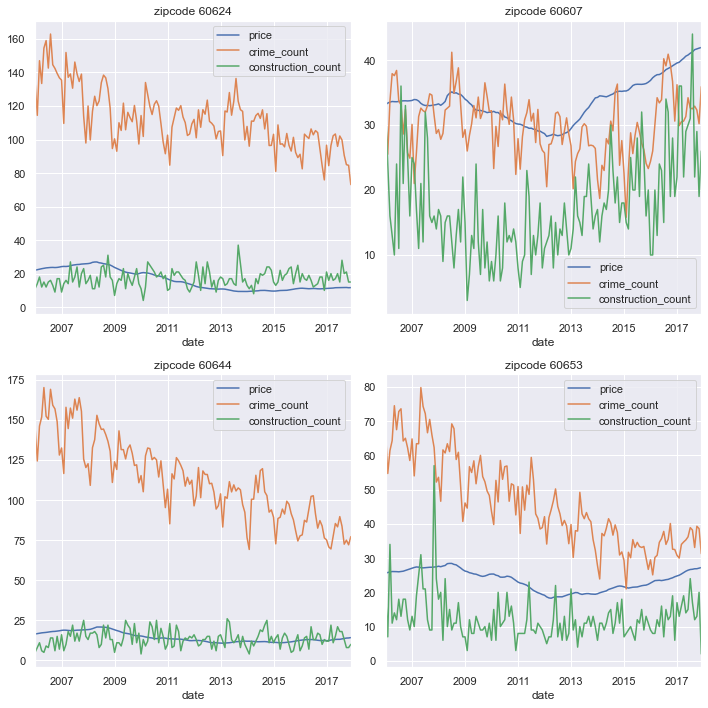

In [38]:
from sklearn.preprocessing import Normalizer
fig, ax = plt.subplots(2,2, figsize=(12,10))
chosen_zipcodes=['60624','60607', '60644', '60653']
idx=0
for i in range(2):
    for j in range(2):
        X_for_plot = (get_merged_data(chosen_zipcodes[idx])[:-24].drop(['zipcode'], axis=1))
        X_for_plot['price'] = X_for_plot['price']/10000
        X_for_plot['crime_count'] = X_for_plot['crime_count']/10
        X_for_plot.plot(figsize=(10,10), ax=ax[i,j]).set( title="zipcode {}".format(chosen_zipcodes[idx]))
        idx+=1

plt.tight_layout()
       

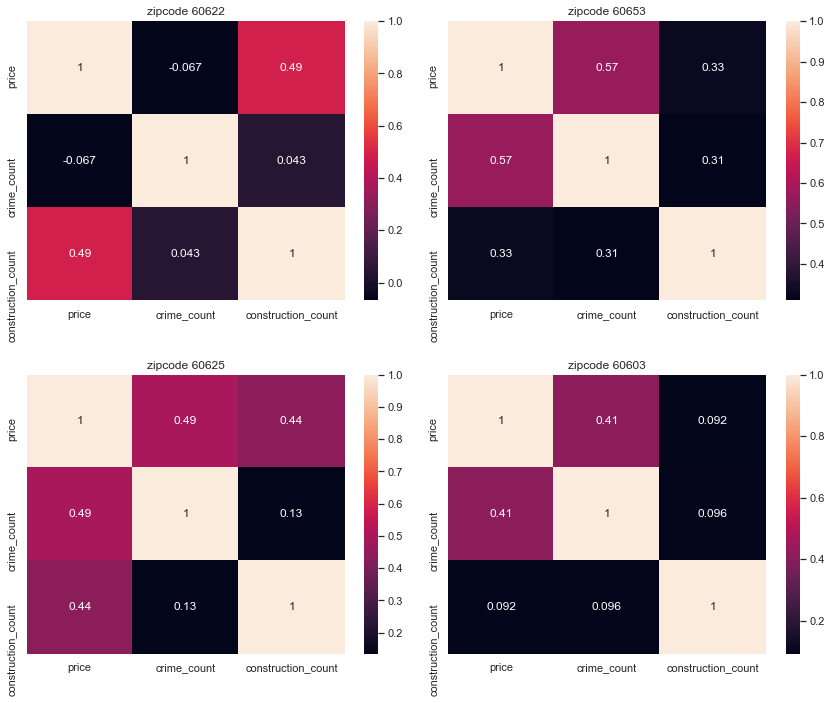

In [39]:
fig, ax = plt.subplots(2,2, figsize=(12,10))
chosen_zipcodes=['60622','60653', '60625', '60603']
idx=0
for i in range(2):
    for j in range(2):
        sns.heatmap(get_merged_data(chosen_zipcodes[idx])[:-24].corr(), annot=True, ax=ax[i,j]).set( title="zipcode {}".format(chosen_zipcodes[idx]))
        idx +=1
plt.tight_layout()
       

In [40]:
# Predicting crime rate and number of building permit being issued

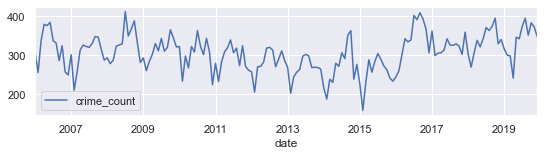

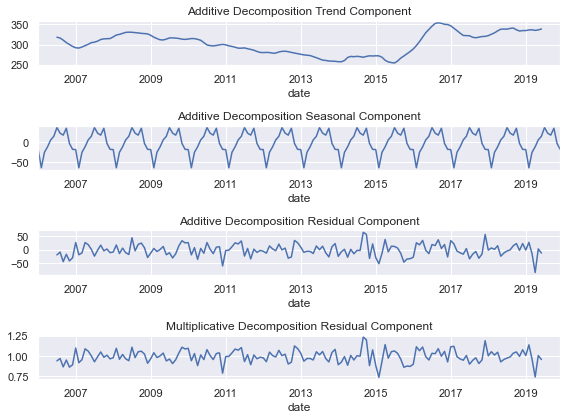

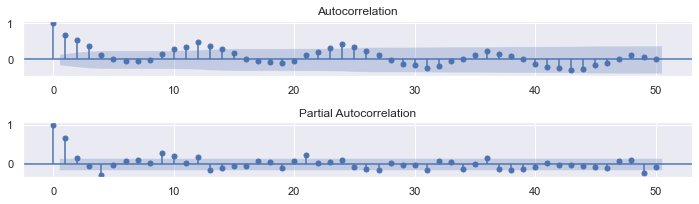

In [41]:
def plot(zipcode, func):
    df = func[zipcode]
    fig, ax = plt.subplots()
    df.plot(figsize=(9,2), ax=ax)
    plt.show()
    
    # Multiplicative Decomposition 
    df_mult = seasonal_decompose(df, model='mult')
    # Additive Decomposition 
    df_add = seasonal_decompose(df, model='add')

    fig, ax = plt.subplots(4,1,figsize=(8, 6))
    df_add.trend.plot(ax=ax[0],title='Additive Decomposition Trend Component')
    df_add.seasonal.plot(ax=ax[1],title='Additive Decomposition Seasonal Component')
    df_add.resid.plot(ax=ax[2],title='Additive Decomposition Residual Component')
    df_mult.resid.plot(ax=ax[3],title='Multiplicative Decomposition Residual Component')
    plt.tight_layout()
    plt.show()
    
    fig, (ax1, ax2) = plt.subplots(2,1,figsize=(10, 3))
    plot_acf(df, lags=50, ax=ax1);
    plot_pacf(df, lags=50, ax=ax2);
    plt.tight_layout()
    
plot( '60607', df_crime_by_zipcode)

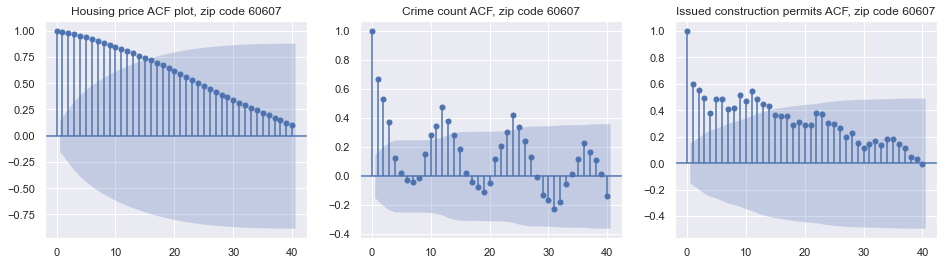

In [42]:
def plot_acf_for_zipcode(zipcode, lags=40):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
    df = get_merged_data(zipcode)
    plot_acf(df.price, lags=lags, ax=ax1, title = 'Housing price ACF plot, zip code {}'.format(zipcode))
    plot_acf(df.crime_count, lags=lags, ax=ax2, title='Crime count ACF, zip code {}'.format(zipcode))
    plot_acf(df.construction_count, lags=lags, ax=ax3, title ='Issued construction permits ACF, zip code {}'.format(zipcode))
    
plot_acf_for_zipcode('60607')

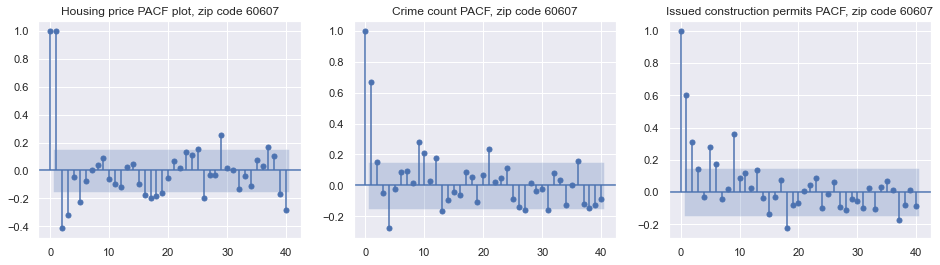

In [43]:
def plot_pacf_for_zipcode(zipcode, lags=40):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16,4))
    df = get_merged_data(zipcode)
    plot_pacf(df.price, lags=lags, ax=ax1, title = 'Housing price PACF plot, zip code {}'.format(zipcode))
    plot_pacf(df.crime_count, lags=lags, ax=ax2, title='Crime count PACF, zip code {}'.format(zipcode))
    plot_pacf(df.construction_count, lags=lags, ax=ax3, title ='Issued construction permits PACF, zip code {}'.format(zipcode))
plot_pacf_for_zipcode('60607')

In [44]:
def get_crime_building_prediction(zipcode, func, forecast_periods= 36, model_info=False, plot_diagnostic=False, plot_forecast=False, summary=True):
    df = func[zipcode]
#     split_idx = int(len(df)*split)
#     train = df[:split_idx]
#     test = df[split_idx:]
    index = -1*forecast_periods
    train = df.iloc[:index]
    test = df[index:]
    model = auto_arima(train,
                       stepwise=True,
                       seasonal=True,
                       D=1,
                       d=1,
                       max_p=4,
                       max_P=4,
                       max_Q=4,
                       max_q=4,
                       suppress_warnings=True,
                       m=12)
    if model_info:
        print(f'order: {model.order}, seasonal order: {model.seasonal_order}')
        print(f"{zipcode} zipcode aic: {model.aic()}")
    if plot_diagnostic:
        model.plot_diagnostics(figsize=(6,6));
        plt.tight_layout()
        
    n_periods= forecast_periods
    fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
    fc_df= pd.DataFrame(fc, index= test.index, columns=['forecast'])
    confint_df = pd.DataFrame(confint, columns=['lower', 'upper'], index=fc_df.index)
    if plot_forecast:
        fig, ax = plt.subplots()
        train.plot(ax=ax, label='train')
        test.plot(label='actual values', color='green', ax=ax)
        fc_df.plot(color='red', ax=ax,label='forecasted values')
        plt.fill_between(x=confint_df.index, y1=confint_df['lower'], y2=confint_df['upper'], color='pink', label='confidence interval')
        plt.legend()
    if summary:
        print(model.summary())
    return fc_df

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -425.359
Date:                            Sun, 16 May 2021   AIC                            858.718
Time:                                    22:45:53   BIC                            869.835
Sample:                                         0   HQIC                           863.232
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1014      0.060      1.677      0.094      -0.017       0.220
ma.L1         -0.7749      0.060   

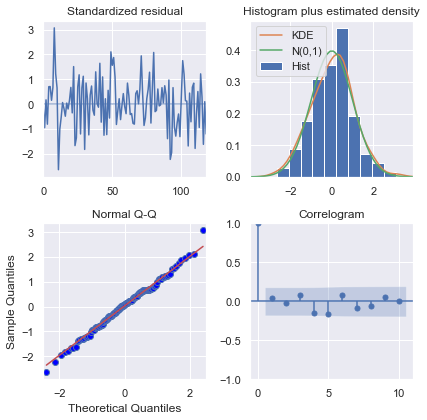

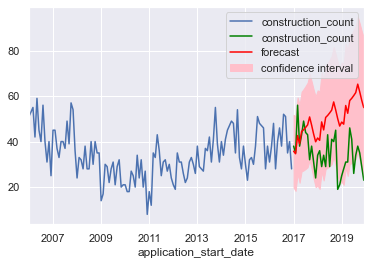

In [45]:
fc_building = get_crime_building_prediction('60622', df_construction_by_zipcode, plot_diagnostic=True, plot_forecast=True) 

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -631.720
Date:                            Sun, 16 May 2021   AIC                           1269.439
Time:                                    22:45:58   BIC                           1277.777
Sample:                                         0   HQIC                          1272.825
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.6093      0.080     -7.652      0.000      -0.765      -0.453
ma.S.L12      -0.7314      0.102   

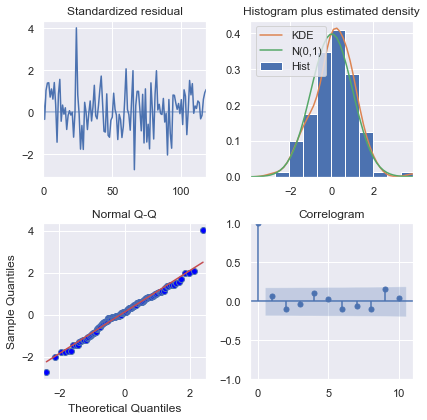

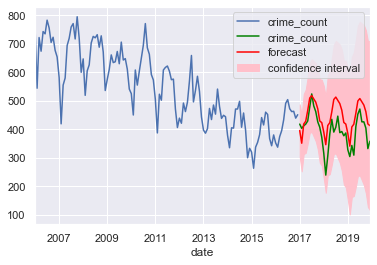

In [46]:
fc_crime = get_crime_building_prediction('60622', df_crime_by_zipcode, plot_diagnostic=True, plot_forecast=True) 

In [49]:
def construction_crime_prediction(zipcode, forecast_periods= 36):
    fc_crime = get_crime_building_prediction(zipcode, df_crime_by_zipcode, forecast_periods=forecast_periods, plot_diagnostic=False, plot_forecast=False, summary=False) 
    fc_crime.columns=['crime_forecast']
    fc_building = get_crime_building_prediction(zipcode, df_construction_by_zipcode, plot_diagnostic=False, plot_forecast=False, summary=False) 
    fc_building.columns = ['building_forecast']
    df = pd.concat((fc_crime, fc_building), axis=1)
    return df
construction_crime_prediction('60605').head(3)

,crime_forecast,building_forecast
date,,
2017-01-31,189.344989,8.455845
2017-02-28,157.836283,9.817519
2017-03-31,189.324620,15.820924


### Auto arima with exogenous variables 
<a id=auto-arima-with-exog></a>

,forecast,actual_price
date,,
2019-12-31,560749.0,505352.0


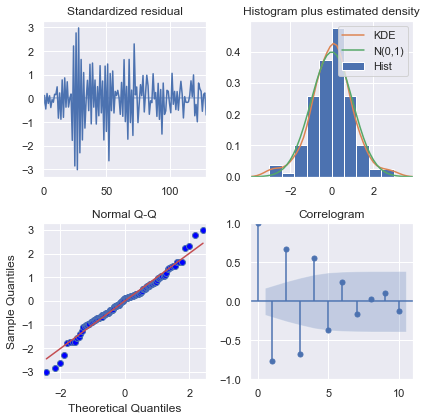

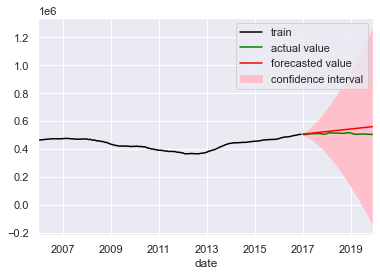

In [50]:
def get_price_with_exog(zipcode, forecast_periods= 36, model_info=False, plot_diagnostic=False, plot_forecast=False):
    df = get_merged_data(zipcode)
    #finding the test and train split

    index = -1*forecast_periods
    train = df[:index]
    test = df[index:]
    x_train = train.price
    exog_train = train.drop(['zipcode', 'price'],axis=1)
    
    x_test = test.price
#     exog_test = test.drop(['zipcode', 'price'],axis=1)
    exog_test = construction_crime_prediction(zipcode, forecast_periods= forecast_periods)
    

    
    model = auto_arima(x_train,
                       x = exog_train,
                       stepwise=True,
                       seasonal=False,
                       max_p=4,
                       max_q=4,
                       suppress_warnings=True,
                       )
    if model_info:
        print(f'order: {model.order}')
        print(f"{zipcode} zipcode aic: {model.aic()}")
    if plot_diagnostic:
        model.plot_diagnostics(figsize=(6,6));
        plt.tight_layout()
        
    fc, confint = model.predict(forecast_periods, return_conf_int=True, x=exog_test)
    fc_df= pd.DataFrame(fc, index= test.index, columns=['forecast'])
    fc_df['actual_price'] = x_test
    confint_df = pd.DataFrame(confint, columns=['lower', 'upper'], index=fc_df.index)
    if plot_forecast:
        fig, ax = plt.subplots()
        x_train.plot(ax=ax, label='train', color='black')
        x_test.plot(label='actual value', color='green', ax=ax)
        fc_df.forecast.plot(color='red', ax=ax,label='forecasted value')
        plt.fill_between(x=confint_df.index, y1=confint_df['lower'], y2=confint_df['upper'], color='pink', label='confidence interval')
        plt.legend()
    return fc_df.iloc[-1:,:]
    
get_price_with_exog('60622', plot_diagnostic=True, plot_forecast=True) 

<a id=results></a>
### Results

In [64]:
get_total_error_for_all_zipcodes(Housing_price_since1996.zipcode.unique(), price_prediction, forecast_periods= 36)

RMSE = 46447.72
MAE=40194.27
r_squared:=0.8600667071120048


In [68]:
def num_corrected_found_zipcodes(model):
    tot_df = pd.DataFrame()
    for zipcode in Housing_price_since1996.zipcode.unique():
        df = model(zipcode,forecast_periods= 36)
        df = pd.concat((df.reset_index(drop=True), df_price_by_zipcode[zipcode].iloc[-37:-36].reset_index(drop=True)), axis=1)
        df.rename(columns={'price':'price_lag3'}, inplace=True)
        df['price_increase'] = df.forecast - df.price_lag3
        tot_df = tot_df.append(df)
    return tot_df[['zipcode', 'price_increase']]
 
  

In [69]:
zipcodes_found_by_univariate_model = num_corrected_found_zipcodes(price_prediction)      
result_univariate_model = zipcodes_found_by_univariate_model.sort_values(by='price_increase', ascending=False).zipcode.values[:10]

In [71]:
zipcodes_with_max_price_increase=['60651', '60612', '60653', '60639', '60642', '60608', '60609','60647', '60607', '60632']
def num_zipcodes_correctly_found(results):
    correctly_predicted_zipcodes = len([zipcode for zipcode in results if zipcode in zipcodes_with_max_price_increase])
    return correctly_predicted_zipcodes

In [72]:
num_zipcodes_correctly_found(result_univariate_model)

4

In [ ]:
# get_total_error_for_all_zipcodes(Housing_price_since1996.zipcode.unique(), get_price_with_exog, forecast_periods= 36)
# zipcodes_found_by_multivariate_model = num_corrected_found_zipcodes(get_price_with_exog)     
# result_multivariate_model = zipcodes_found_by_multivariate_model.sort_values(by='price_increase', ascending=False).zipcode.values[:10]
# num_zipcodes_correctly_found(result_multivariate_model)